# Assignment 2 - Dynamic Programming


In the second assignment, you will implement four dynamic programming algorithms:

- Implement DP Policy Evaluation (4 Points)
- Implement DP Policy Improvement (4 Points)
- Implement DP Policy Iteration (2 Points)
- Implement DP Value Iteration (5 Points)
- Answer some Theory Questions (8 Points)

**Do not forget to restart the kernel and run all the code cells before saving and submitting the assignment!**



    
Before you start with this problem:
- Study the corresponding slide deck(s) and consider re-watching the lecture recording(s).
- Internalize the material until you feel confident you can work with or implement them yourself. Only then start working on this assignment; otherwise, you will waste a lot of time.

---


<div class="alert alert-warning">

**Due-Date:** see Moodle
   
**Constraints**: Operations on SciPy and NumPy arrays only.
  
**Automatic Grading:** 

- Replace the placeholders `# YOUR CODE HERE` `raise NotImplementedError()` / `YOUR ANSWER HERE` with your code / answers.
- make sure to remove all `raise NotImplementedError()` statements
- Put results in the corresponding variable; otherwise, we will not grade your solution (i.e., we assign 0 points).
- Do not delete or add cells.
    
**Submission:** Submit the notebook via Moodle.
- naming convention: `k<8 digits of student ID>.ipynb`
- correct naming for student with id k01234567: k01234567.ipynb
- some examples of incorrectly named submissions:
    - k1234567.ipynb (7 digits)
    - k01234567.pdf (converted to pdf)
    - k01234567.html (converted to html)
    - 01234567.ipynb (k is missing)
    - k01324567.ipynb (incorrect student ID)
    -  ...
- notbooks that cannot be assign automatically will not be graded

**Questions?** Post it into the forum!
</div>

## Running code cells

To execute a code cell, use either `Ctrl-Enter`, `Shift-Enter`, or the GUI buttons above.

# The Fishlake Environment

You should be familiar with the inner workings of the `Fishlake` Environment from the lecture slides. We will now use this environment to test dynamic programming prediction and control algorithms.

If you `render` the environment, it will look something like this:
```
WWWM
WRWF
SWWW

W ... W.ater (may be very streamy, and mess with the fish's movement)
S ... S.tart (a state in which the fish may start an episode)
R ... R.ock (this is essentially a hole in the map, it is not a state!)

M ... M.aize (delicious fish food; entering this state from any other
              state will give +1 reward, and end the episode)
F ... F.isherman (evil; entering this state from any other state will
                  give -1 reward, and end the episode)
```

<h2>Preliminaries</h2>

What follows are the imports, the generation of the environment, and some helper functions. You have to run this cell first before starting to implement and run your algorithms.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
import pprint
import fishlake
from fishlake import plot_policy, plot_value_function
import testing
from typing import Tuple

pp = pprint.PrettyPrinter(depth=4)
np.set_printoptions(precision=4, suppress=True, threshold=200)

## Quickstart

Here, we give you a few hints on how to use the openai gym, what the data formats look like, etc.

### Loading the Environment and Moving Around

In [2]:
# load the environment
lake_env = gym.make('FishlakeStreamy-v0')

# reset it (set it back to its inital state (not strictly necessary here...))
start_state = lake_env.reset()[0]

# if there's only one 'S' tile in the lake description, than the agent will start in this state with probability = 1
print('start state', start_state)

# let's start by looking at our environment
lake_env.render()

start state 7

WWWM
WRWF
SWWW


In [3]:
# now let's try to move around:
result = lake_env.step(2) # let's try to move right
print(result)
# the result will look something like this:
# (8, 0, False, False, {'prob': 0.8})

(8, 0, False, False, {'prob': 0.8})


In [4]:
# (8, 0, ...           means that we are now in state 8, and we got 0 reward for our last step
# ..., False, ...      means it is not a goal state
# ..., False, ...      means that the episode was not truncated
# ..., {'prob': 0.8})  denotes the transition probability from the previous state to the current state

# we can have another look at our environment (chances are that the agent moved away from the inital square)
lake_env.render()

  (Right)
WWWM
WRWF
SWWW


### Accessing Information about the Environment

In [5]:
# we have perfect information about our environment (and you should make use of it in your code...):
print("Number of States: ", lake_env.observation_space.n)  # we can access the number of states
print("Number of Actions: ", lake_env.action_space.n)          # we can access the number of actions

Number of States:  11
Number of Actions:  4


In [6]:
# the dynamics are given as a dictionary containing dictionaries containing lists
# you can print the full dynamics by uncommenting the next line (it's a lot of text...)
# print("Dynamics: ", lake_env.P)
state = 2
print(f"\nFor example, the dynamics for state {state} are defined via this dictionary:\n")
pp.pprint(lake_env.P[state])

state = 1
action = 3
print(f"\nEach entry in this dictionary corresponds to transition probabilities of one action (0-3). If the agent is in state {state} and chooses action {action}, the dynamics are:\n")
print(lake_env.P[state][action])


For example, the dynamics for state 2 are defined via this dictionary:

{0: [(0.8, 1, 0, False), (0.1, 2, 0, False), (0.1, 5, 0, False)],
 1: [(0.8, 5, 0, False), (0.1, 1, 0, False), (0.1, 3, 1, True)],
 2: [(0.8, 3, 1, True), (0.1, 2, 0, False), (0.1, 5, 0, False)],
 3: [(0.8, 2, 0, False), (0.1, 1, 0, False), (0.1, 3, 1, True)]}

Each entry in this dictionary corresponds to transition probabilities of one action (0-3). If the agent is in state 1 and chooses action 3, the dynamics are:

[(0.8, 1, 0, False), (0.1, 0, 0, False), (0.1, 2, 0, False)]


In [7]:
state = 2
action = 2
print(f"\nLet's iterate over the dynamics of state {state} when selecting action {action}:")
for p_next_state, next_state, reward, _ in lake_env.P[state][action]:
    print((p_next_state, next_state, reward), "means transition probability: ", p_next_state, "next state:", next_state, "reward:", reward)


Let's iterate over the dynamics of state 2 when selecting action 2:
(0.8, 3, 1) means transition probability:  0.8 next state: 3 reward: 1
(0.1, 2, 0) means transition probability:  0.1 next state: 2 reward: 0
(0.1, 5, 0) means transition probability:  0.1 next state: 5 reward: 0


### Storing the Policy and the Value Function
We will use a 2 dimensional `np.array` to store policies.
- the number of rows is given by the number of states
- the number of columns is given by the number of actions

The 'take a random action'-policy:
[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]

Let's plot the random policy:


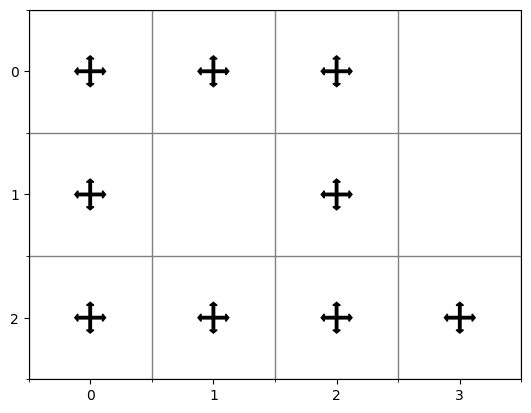


Note that the lenght of the arrows corresponds to the probability of selecting the action.


In [8]:
# let's create a random policy:
random_policy = np.ones([
    lake_env.observation_space.n,
    lake_env.action_space.n
])
random_policy = random_policy / lake_env.action_space.n

print("The 'take a random action'-policy:")
print(random_policy)

print("\nLet's plot the random policy:")
fig, ax = plt.subplots()
plot_policy(ax, lake_env, random_policy)
plt.show()
print("\nNote that the lenght of the arrows corresponds to the probability of selecting the action.")

We will use a 1 dimensional `np.array` to store state-value functions.

The length of this array corresponds to the number of states.


A Value Function initialized with 0:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Let's plot the all-zero value function:


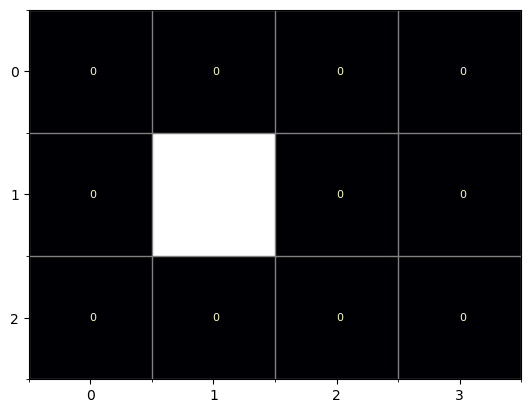

In [9]:
V = np.zeros(lake_env.observation_space.n)

print("\nA Value Function initialized with 0:\n")
print(V)

print("\nLet's plot the all-zero value function:")
fig, ax = plt.subplots()
plot_value_function(ax, lake_env, V)
plt.show()

## (1) Policy Evaluation

<div class="alert alert-warning">
    Implement the policy evaluation algorithm (4 points).
</div>

This is the first function you have to implement. We would suggest that you implement the in-place version of policy evaluation, as it is the simpler (and also the preferable) variant.

In [10]:
def policy_evaluation(env: gym.Env, policy: np.ndarray, initial_V: np.ndarray, gamma: float, theta: float = 1e-8) -> np.ndarray:
    """
    Policy Evaluation via Dynamic Programming
    
    Args:
        env: the openai gym environment
        policy: the policy to be evaluated
        initial_V: the initial value function
        gamma: the discount factor
        theta: the stopping criterion (leave this alone)
    
    Returns:
        the value function for a given policy
    """
    V = initial_V.copy()
    # YOUR CODE HERE
    # raise NotImplementedError()
    delta = float('inf')
    while delta > theta:
        V_k = V.copy()
        for state, actions in enumerate(policy):
            policy_sum = 0
            for action, p_a in enumerate(actions):
                q_pi_sum = 0
                for p_next_state, next_state, reward, _ in env.P[state][action]:
                    q_pi_sum+=p_next_state*(reward+gamma*V[next_state])
                policy_sum += p_a*q_pi_sum
                # summing over probability to take each action * summed state-action transition probabilities to new states for that action
            V[state] = policy_sum

        delta = np.max(np.abs(V_k - V))
    return V

In [11]:
# let's create a random policy:
random_policy = np.ones([
    lake_env.observation_space.n,
    lake_env.action_space.n
])
random_policy = random_policy / lake_env.action_space.n

# we will now evaluate the random policy, and obtain the corresponding value function
V_0 = np.zeros(lake_env.observation_space.n)
V_0 = policy_evaluation(lake_env, random_policy, V_0, gamma=0.9)

# at least one value should be different from the intial value, otherwise we assume it's not implemented/ incorrect ...
assert testing.is_type(V_0, np.ndarray)
assert testing.numpy_array_has_shape(V_0, (lake_env.observation_space.n,))
assert np.any(V_0 != 0), "your implementation of policy_evaluation returns the intial values without modifications"

### Run DP Policy Evaluation 
Okay, let's now run the algorithm on the random policy in the fishlake environment.

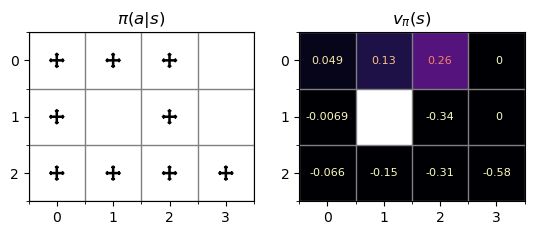

In [12]:
V = policy_evaluation(lake_env, random_policy, V_0, gamma=0.9)

fig, axes = plt.subplots(ncols=2)
plot_policy(axes[0], lake_env, random_policy)

plot_value_function(axes[1], lake_env, V)
axes[0].set_title('$\pi(a | s)$')
axes[1].set_title('$v_{\pi}(s)$')
plt.show()

## (2) Policy Improvement

<div class="alert alert-warning">
    Implement a one step lookahead and the policy improvement agorithm (4 points).
</div>

Here you have to implement one step lookahead and the policy improvement algorithm. We will use policy improvement  later on within the policy iteration algorithm to compute the optimal policy.

Onset step lookahead computes the state-action values for a given state using the current state values and the dynamics. This is usefull in several dynamic programming algorithms.

In [13]:
def one_step_lookahead(env: gym.Env, state: int, V: np.ndarray, gamma: float) -> np.ndarray:
    """   
    
    Compute the action value q(s = state, a) for all actions a.
    
    Args:
        env: the openai gym environment
        state: index of the state in environment to compute the action vales for
        V: current value function
        gamma: discount factor
    
    Returns:
        a 1D numpy array containing the action values for state s; positions in the array correspond to action indices
    """
    A = np.zeros(env.action_space.n)
    # YOUR CODE HERE
    # raise NotImplementedError()

    q_pi= np.zeros(len(A))
    for action in range(len(A)):
        for p_next_state, next_state, reward, _ in env.P[state][action]:
            A[action]+=p_next_state*(reward+gamma*V[next_state]) # summed up q for every action

    return A

In [14]:
gamma = 0.9
action_values = one_step_lookahead(lake_env, 0, np.ones(lake_env.observation_space.n), gamma)

assert testing.is_type(action_values, np.ndarray)
assert testing.numpy_array_has_shape(action_values, (lake_env.action_space.n,))
assert not all(action_values == 0), "initial values of action-values should be different from the initialization"

Use the one_step_lookahead method to implement policy improvement.

**Important:** use `np.argmax` to select the action that has the highest value (see, Eq. 4.9, Chapter 4, p.79, in the RL Book.)

In [15]:
def policy_improvement(env: gym.Env, old_policy: np.ndarray, V: np.ndarray, gamma: float) -> Tuple[np.ndarray, bool]:
    """
    Policy Improvement
    
    Args:
        env: the openai gym environment
        old_policy: the policy to be evaluated
        V: the value function of the policy
        gamma: discount factor
    
    Returns:
        a tuple consisting of the improved policy (a numpy array)
        and a boolean, indicating it the policy is stable (i.e. was not changed)
    """
    improved_policy = np.zeros_like(old_policy)
    policy_stable = True

    # use one_step_lookahead here to find the new action
    # YOUR CODE HERE
    # raise NotImplementedError()
    for state, actions in enumerate(improved_policy):
        A = one_step_lookahead(env, state, V, gamma)
        improved_policy[state][np.argmax(A)] = 1

    policy_stable = bool(np.isclose(improved_policy, old_policy).all())
        
    return improved_policy, policy_stable

In [16]:
gamma = 0.9

# again, we start with a random policy
policy_0 = np.ones([
    lake_env.observation_space.n,
    lake_env.action_space.n
])
policy_0 = policy_0 / lake_env.action_space.n

# we will then evaluate the random policy and obtain its associated value function
V_0 = policy_evaluation(lake_env, policy_0, np.zeros(lake_env.observation_space.n), gamma=gamma)

# do one step of policy improvement
policy_1, policy_stable = policy_improvement(lake_env, policy_0, V_0, gamma=gamma)

# check data type of result
assert testing.is_type(policy_stable, bool)
assert testing.is_type(policy_1, np.ndarray)

# check if valid policy
assert testing.numpy_array_has_shape(policy_1, policy_0.shape)
assert np.isclose(policy_1.sum(axis=1), 1).all(), 'Probabilities of all actions must sum to one.'

# compute values for new policy
V_1 = policy_evaluation(lake_env, policy_1, V_0, gamma=gamma)

### Run Policy Improvement

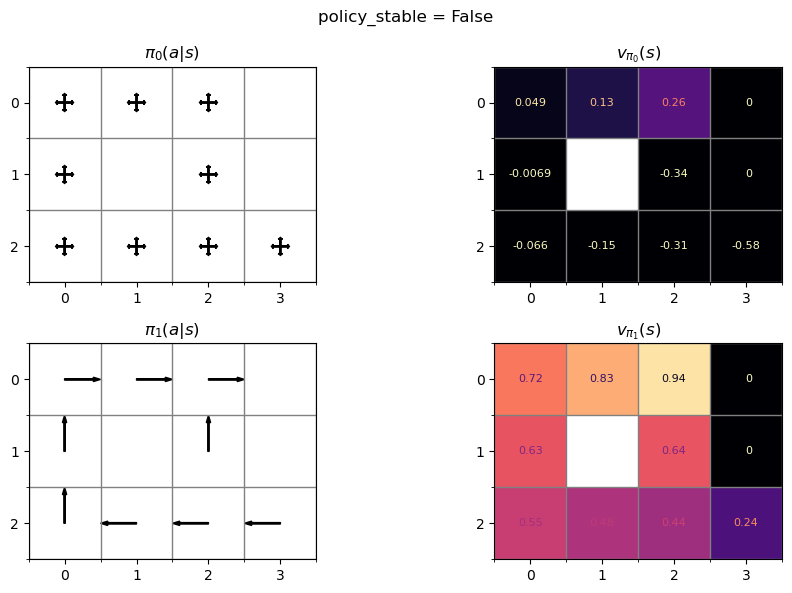

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
fig.suptitle(f'policy_stable = {policy_stable}')
axes[0, 0].set_title('$\pi_0(a | s)$')
axes[0, 1].set_title('$v_{\pi_0}(s)$')
axes[1, 0].set_title('$\pi_1(a | s)$')
axes[1, 1].set_title('$v_{\pi_1}(s)$')

plot_policy(axes[0, 0], lake_env, policy_0)
plot_value_function(axes[0, 1], lake_env, V_0)
plot_policy(axes[1, 0], lake_env, policy_1)
plot_value_function(axes[1, 1], lake_env, V_1)
plt.tight_layout()
plt.show()

## (3) Policy Iteration

<div class="alert alert-warning">
    Implement the Policy Iteration Algorithm (2 points).
</div>

This one should be easy now -- if you have correctly implemented the evaluation and the improvement algorithms above...

In [18]:
def policy_iteration(env: gym.Env, policy: np.ndarray, gamma: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Policy Iteration
    
    Args:
        env: the openai gym environment
        policy: the policy to be evaluated
        gamma: the discount factor
    
    Returns:
        a tuple consisting of
        the optimal policy
        and the respective value function
    """
    
    V = np.zeros(env.observation_space.n)
    policy = np.copy(policy)
    
    # use policy_evaluation and policy_improvement here
    # YOUR CODE HERE
    # raise NotImplementedError()
    
    while True:
        a_old = policy # not doing it state by state, since policy stores all states       
        V = policy_evaluation(env, policy, V, gamma)
        greedy_policy, policy_stable = policy_improvement(env, policy, V, gamma)
        policy = greedy_policy
    
        if policy_stable==True:
            V = policy_evaluation(env, policy, V, gamma)
            break

    return policy, V
    

In [19]:
gamma = 0.9

# again, we start with a random policy
policy_0 = np.ones([
    lake_env.observation_space.n,
    lake_env.action_space.n
])
policy_0 = policy_0 / lake_env.action_space.n

# do policy iteration until convergence
policy_optimal, V_optimal = policy_iteration(lake_env, policy_0, gamma)

# check data type of result
assert testing.is_type(policy_optimal, np.ndarray)
assert testing.is_type(V_optimal, np.ndarray)

# check if valid policy and value array
assert testing.numpy_array_has_shape(policy_optimal, policy_0.shape)
assert testing.numpy_array_has_shape(V_optimal, (lake_env.observation_space.n,))

# some more checks ...
assert np.isclose(policy_1.sum(axis=1), 1).all(), 'Probabilities of all actions must sum to one.'
assert not np.isclose(policy_optimal, policy_0).all(), "Initial policy not updated."
assert not all(V_optimal == 0), "Initial values not updated."

### Run DP Policy Iteration

Next, let's improve a random policy and compute an optimal policy by using policy iteration.

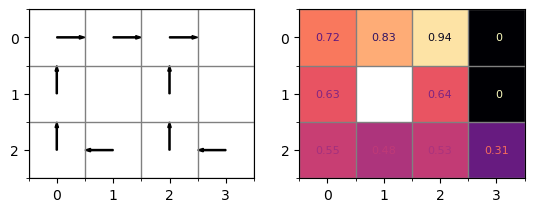

In [20]:
# let's create a random policy
policy = np.ones([lake_env.observation_space.n, lake_env.action_space.n]) / lake_env.action_space.n

# and now let's compute an optimal policy via the policy iteration algorithm
policy, value_function = policy_iteration(lake_env, policy, gamma=0.9)

fig, axes = plt.subplots(ncols=2)
plot_policy(axes[0], lake_env, policy)
plot_value_function(axes[1], lake_env, value_function)
plt.show()

## (4) Value Iteration

<div class="alert alert-warning">
    Implement the Value Iteration Algorithm (5 points).
</div>

Hint: use the `one_step_lookahead` function.

In [21]:
def value_iteration(env: gym.Env, gamma: float, theta: float = 1e-8) -> Tuple[np.ndarray, np.ndarray]:
    """
    Value Iteration
    
    Args:
        env: the openai gym environment
        gamma: discount factor gamma
        theta: the stopping criterion
    
    Returns:
        a tuple consisting of
        the optimal policy
        and the respective value function
    """
    V = np.zeros(env.observation_space.n)
    policy = np.zeros([env.observation_space.n, env.action_space.n])
    
    # YOUR CODE HERE
    # raise NotImplementedError()

    while True:
        delta = 0
        for state, value in enumerate(V):
            A = one_step_lookahead(env, state, V, gamma)
            V[state] = np.max(A)
                              
            delta = max(delta, abs(value-V[state]))
                        
        if delta < theta:
            policy,_ = policy_improvement(env, policy, V, gamma)            
            break
                        
    return policy, V

In [22]:
gamma = 0.9

policy_optimal, V_optimal = value_iteration(lake_env, gamma)

# check the results data type
assert testing.is_type(policy_optimal, np.ndarray)
assert testing.is_type(V_optimal, np.ndarray)

# check if valid policy and value array
assert testing.numpy_array_has_shape(policy_optimal, (lake_env.observation_space.n, lake_env.action_space.n))
assert testing.numpy_array_has_shape(V_optimal, (lake_env.observation_space.n,))

# some more checks ...
assert not all(V_optimal == 0), "Initial values not updated."
assert (policy_optimal.sum(axis=1) == 1).all(), 'Probabilities of all actions must sum to one.'

### Run DP Value Iteration

Finally, let's compute the optimal policy by using value iteration. Obviously the result should be very similar to the policy interation algorithm.

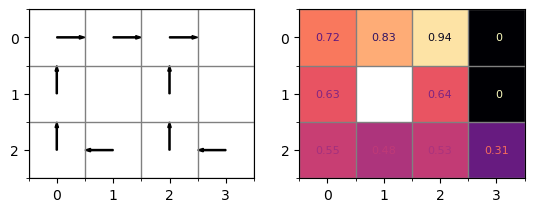

In [23]:
# let's redo this with value iteration...
opt_policy, opt_value_function = value_iteration(lake_env, gamma=0.9)

fig, axes = plt.subplots(ncols=2)
plot_policy(axes[0], lake_env, opt_policy)
plot_value_function(axes[1], lake_env, opt_value_function)
plt.show()

## (5) Comprehension Exercise

#### 5.1 True/False Questions
<div class="alert alert-warning">
    Answer the following True/False questions by storing your answer into the corresponding variable.
</div>

Specify whether the following statements are True or False **for MDPs in general** (1 point each):
1. There is exactly one optimal policy.
2. $q_*(s, a)$ gives the value of taking the optimal action $a$ in state $s$ and following the optimal policy thereafter.
3. Adding a constant value to all rewards will not change the optimal policy in continuous tasks with $\gamma < 1.0$.
4. Adding a constant value to all rewards will not change the optimal policy in episodic tasks with $\gamma = 1.0$.

In [24]:
# store True or False for the corresponding question
results = {
    '1': False,
    '2': True,
    '3': True,
    '4': False
}
# YOUR CODE HERE
# raise NotImplementedError()

In [25]:
assert testing.is_type(results['1'], bool)

In [26]:
assert testing.is_type(results['2'], bool)

In [27]:
assert testing.is_type(results['3'], bool)

In [28]:
assert testing.is_type(results['4'], bool)

<div class="alert alert-warning">
    Give a **short answer** for the following questions/ tasks (2 points each).
</div>

#### 5.2. Maze Running

Imagine that you are designing a robot to run a maze. You decide to give it a reward of +1 for escaping from the maze and a reward of zero at all other times. The task seems to break down naturally into episodes — the successive runs through the maze — so you decide to treat it as an episodic task, where the goal is to maximize expected total undiscounted reward ($\gamma = 1$). After running the learning agent for a while, you find that it is showing no improvement in escaping from the maze. 

What is going wrong? Have you effectively communicated to the agent what you want it to achieve? Give a short and concise answer (two sentences max)!

(Source: Sutton and Barto, "Reinforcement Learning: An Introduction")

After certain amount of runs agent will have found the exit at least once, updated that sequence of moves as it's optimal policy and then used it onwards, since there is nothing to improve - it has achieved the max reward it could ever get. Reward signal is too sparse (only when goal reached, not how goal reached), there is no penalty (=negative reward) for amount of steps taken, so agent doesn't know it should have improved something.

#### 5.3 Alternative Policy Evaluation Update Rule

Give an expression analogous to the policy evaluation update rule $$v_{k+1}(s) := \sum_{a} \pi(a \mid s) \sum_{s', r} p(s', r \mid s,a) \big [ r + \gamma v_k(s') \big ]$$ but for action-value estimates $q_k(s, a)$ instead of state-value estimates $v_k(s)$. Use previous action-value estimates $q_{k}(s, a)$ instead of state-value estimates $v_{k}(s)$ to compute the updated value $q_{k+1}(s, a)$

**Hint:** Use $\LaTeX$ math to write down the expression.

$q_{k+1}(s, a) = \dots$

$$ q_{k+1}(s,a) = \sum_{s', r} p(s', r \mid s,a) \big [ r + \gamma   v_{k}(s') \big ] $$

We know $v_k (s') = \sum_{a} \pi(a \mid s') \sum_{s', r} q_{k-1}(s', a) = \sum_{a'} \pi(a' \mid s') \sum_{s', r} q_{k} (s', a') $ we take the action that leads to the previous-k state

Substituting back, we get:


$$ q_{k+1}(s,a) = \sum_{s', r} p(s', r \mid s,a) \big [ r + \gamma   \sum_{a'} \pi(a' \mid s') \sum_{s', r} q_{k} (s', a') \big ] $$





